<a href="https://colab.research.google.com/github/itsmevidhyak/Research-Stuff/blob/master/Capital%20Allocation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import packages
import collections
import matplotlib.pyplot as plt
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import seaborn as sns
import numpy as np

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

try:
  tf.compat.v1.enable_eager_execution()
except ValueError:
  pass

print(tf.__version__)
print(tfp.__version__)
tf.executing_eagerly()


1.15.0
0.7.0


True

In [0]:
import pandas as pd

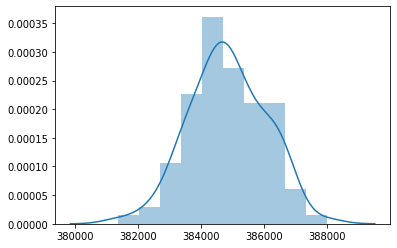

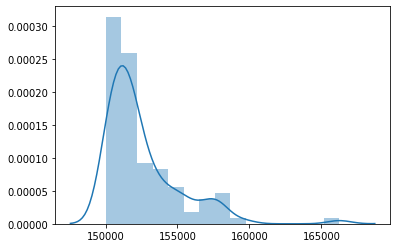

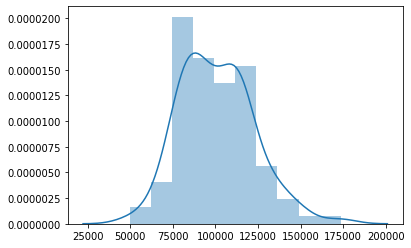

In [62]:
# Simulate 3 sub portfolios from log normal distribution with mean = 10, sigma = 3.5
lob1, lob2, lob3 = [ tfd.Gamma(concentration = 77000, rate = 1.0/5.0),
                     tfd.Pareto(concentration = 70.0, scale = 150000),
                     tfd.LogNormal(loc = 11.5, scale = 0.19804)]
# Draw samples and plot them
sns.distplot(lob1.sample(100).numpy().ravel())
plt.show()
sns.distplot(lob2.sample(100).numpy().ravel())
plt.show()
sns.distplot(lob3.sample(100).numpy().ravel())
plt.show()

In [63]:
lob3.sample(10).numpy().ravel()

array([ 93664.05 , 100215.06 ,  87155.664, 113063.83 , 130006.79 ,
        95920.625,  74323.445, 101356.914,  85718.32 , 101909.195],
      dtype=float32)

In [80]:
Loss_on_Lob1 = pd.DataFrame(lob1.sample(100).numpy().ravel())
Loss_on_Lob2 = pd.DataFrame(lob2.sample(100).numpy().ravel())
Loss_on_Lob3 = pd.DataFrame(lob3.sample(100).numpy().ravel())
All_Loss = pd.concat([Loss_on_Lob1, Loss_on_Lob2, Loss_on_Lob3], axis = 1)
names = ['EL', 'MA', 'PD']
All_Loss.columns = names
All_Loss

,EL,MA,PD
0,383795.68750,153404.437500,136751.031250
1,384544.96875,151659.015625,105205.921875
2,383435.59375,150162.968750,115847.765625
3,386179.84375,150976.437500,133610.843750
4,385866.43750,151763.328125,120658.187500
...,...,...,...
95,384552.31250,150091.093750,102041.062500
96,386273.25000,150174.296875,74819.625000
97,385209.68750,151188.234375,82399.367188
98,387667.96875,150278.156250,92862.414062


686653.8296874999

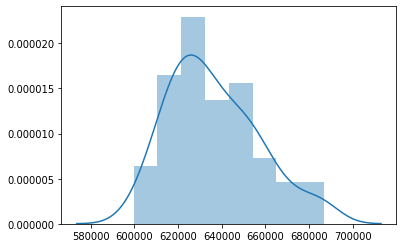

In [81]:
Aggregate_Losses = All_Loss.sum(axis = 1)
sns.distplot(Aggregate_Losses)
Aggregate_Capital = np.quantile(Aggregate_Losses, 0.995)
Aggregate_Capital

In [82]:
Capital_1 = np.quantile(Loss_on_Lob1, 0.995)
Capital_2 = np.quantile(Loss_on_Lob2, 0.995)
Capital_3 = np.quantile(Loss_on_Lob3, 0.995)
k = [Capital_1, Capital_2, Capital_3]
k
np.sum(k)

695336.2880468749

## Model

We will use Covariance allocation principle. Let us assume the purpose of the allocation exercise is to rank the business units according to levels
of profitability.

Reference: https://www.researchgate.net/publication/24046637_Optimal_capital_allocation_principles

Let $S$ be the aggregate loss in a portfolio of $n$ individual losses $X_1, X_2, ..., X_n$ expected to materialise at a future time horizon, say time $T$. Assume $X_i$ be the loss faced by the business unit $i$.

Let Aggregate Loss be, 

$$ S =  \Sigma_{i = 1}^{n} X_i$$

Let the Aggregate Capital determined by the company be,

$$ K =  \Sigma_{i = 1}^{n} K_i$$

where $K_i$ is the capital to be allocated to $i^{th}$ loss. $K$ is termed as full allocation requirement. 

By virtue of covariance allocation principle by Overbeck (2000), 

$$K_i = \frac {K} {Var[S]} . Cov (X_i, S), \ \ \ \ i = 1, 2, ..., n $$

where $Cov (X_i, S) $ is the covariance between the individual loss $X_i$ and the aggregate loss $S$ and $Var[S] $ is the variance of the aggregate loss $S$.

Because the sum of these individual covariances is equal to the variance of the aggregate loss, the full allocation requirement is automatically satisfied in this case.

One important advantage of the covariance allocation principle is that, it explicitly takes into account the dependence structure of the random losses $X_1 ,X_2 ,...,X_n $. Business units with a loss that is more correlated with the aggregate portfolio loss $S$ are penalised by requiring them to hold a larger amount of capital than those which are less correlated.

In [136]:
K = Aggregate_Capital
Loss = np.matrix(All_Loss)
S = np.matrix(Aggregate_Losses)

def mean(x):
    return sum(x) / len(x)

def cov(x, y):
    x_mean = mean(x)
    y_mean = mean(y)
    data = [(x[i] - x_mean) * (y[i] - y_mean)
            for i in range(len(x))]
    return sum(data) / (len(data) - 1)

cov1 = cov(Loss[:,0], S.T)
cov2 = cov(Loss[:,1], S.T)
cov3 = cov(Loss[:,2], S.T)

Total_cov = np.concatenate((cov1, cov2, cov3))

K_i = (K / np.var(S)) * Total_cov
K_i

# Sense check whether there is a diversification benefit from the capital allocation
if np.sum(K_i) < np.sum(k): print(np.sum(k) - np.sum(K_i))

1746.7255468749208


In [128]:
K / np.var(S)

0.0016289423522580654

In [131]:
type(cov1)

numpy.matrix